In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [8]:
def get_user_animelist(username: str, client_id: str):
    # Loads list of anime from MAL for a given user
    url = f'https://api.myanimelist.net/v2/users/{username}/animelist?limit=500'
    headers = {
        'X-MAL-CLIENT-ID': client_id
    }
    params = {
        'fields': 'id, title, list_status{score,status}, start_season{year}, mean, genres, popularity, media_type, rating, num_episodes, studios, num_list_users,favorites'
    }

    all_data = []
    next_page = url

    while next_page:
        response = requests.get(next_page, headers=headers, params=params if next_page == url else None)
        if response.status_code != 200:
            raise ValueError(f"Error with API request: {response.status_code} - {response.text}")

        data = response.json()
        all_data.extend(data['data'])
        next_page = data.get("paging", {}).get("next")

        print(f"Loaded {len(all_data)} anime...")

    return all_data

In [9]:
def to_dataframe(all_data):
    rows = []
    for item in all_data:
        anime = item['node']
        score = item.get('list_status', {}).get('score')
        status = item.get('list_status', {}).get('status')
        # num_episodes_watched = item.get('list_status', {}).get('num_episodes_watched')
        year = item.get('node', {}).get('start_season', {}).get('year')
        rows.append({
            "id": anime['id'],
            "title": anime['title'],
            "mean": anime.get('mean'),
            "genres": [g['name'] for g in anime.get('genres', [])],
            "studios": [s['name'] for s in anime.get('studios', [])],
            "rating": anime.get('rating'),
            "year": year,
            "type": anime.get('media_type'),
            "popularity": anime.get('popularity'),
            "score": score,
            "status": status,
            "members": anime['num_list_users'],
            "num_episodes": anime['num_episodes'],
        })
    
    df = pd.DataFrame(rows)
    df['studios'] = df['studios'].str.join(", ")
    df['genres'] = df['genres'].str.join(", ")

    return df

In [10]:
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
USER_NAME = config.get('USER','USER_NAME').strip()
CLIENT_ID = config.get('USER','CLIENT_ID').strip()

In [11]:
data = get_user_animelist(USER_NAME, CLIENT_ID)

Loaded 500 anime...
Loaded 1000 anime...
Loaded 1500 anime...
Loaded 2000 anime...
Loaded 2500 anime...
Loaded 3000 anime...
Loaded 3500 anime...
Loaded 4000 anime...
Loaded 4500 anime...
Loaded 5000 anime...
Loaded 5059 anime...


In [12]:
df = to_dataframe(data)

In [29]:
df = df[df['score']>0].copy()

In [30]:
# Basic information
print("Dataset size:", df.shape)
print("\n" + "="*50)
print("FIRST ROWS:")
print(df.head(10))
print("\n" + "="*50)
print("LAST ROWS:")
print(df.tail(10))
print("\n" + "="*50)
print("RANDOM SAMPLE:")
print(df.sample(10))

Dataset size: (3726, 13)

FIRST ROWS:
       id                                              title  mean  \
1    8481                           "Bungaku Shoujo" Memoire  7.24   
5     873                                       .hack//Roots  6.85   
6     298                  .hack//Tasogare no Udewa Densetsu  6.55   
8    1583                                              009-1  6.20   
9    5525                                           07-Ghost  7.18   
10  41380         100-man no Inochi no Ue ni Ore wa Tatteiru  6.52   
11  44881  100-man no Inochi no Ue ni Ore wa Tatteiru 2nd...  6.79   
12   6682                                             11eyes  6.03   
13  23579                                            12-sai.  6.24   
14  32601                12-sai.: Chicchana Mune no Tokimeki  6.40   

                                               genres                 studios  \
1                              Drama, Romance, School          Production I.G   
5               Adventure, Dr

In [31]:
# Data types
print("DATA TYPES INFORMATION:")
print(df.info())
print("\n" + "="*50)

# Descriptive statistics
print("DESCRIPTIVE STATISTICS:")
print(df.describe(include='all').T)
print("\n" + "="*50)

# Unique values for categorical features
print("UNIQUE VALUES:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() < 20:
        print(f"  Values: {df[col].unique()}\n")

DATA TYPES INFORMATION:
<class 'pandas.core.frame.DataFrame'>
Index: 3726 entries, 1 to 5058
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3726 non-null   int64  
 1   title         3726 non-null   object 
 2   mean          3726 non-null   float64
 3   genres        3726 non-null   object 
 4   studios       3726 non-null   object 
 5   rating        3726 non-null   object 
 6   year          3723 non-null   float64
 7   type          3726 non-null   object 
 8   popularity    3726 non-null   int64  
 9   score         3726 non-null   int64  
 10  status        3726 non-null   object 
 11  members       3726 non-null   int64  
 12  num_episodes  3726 non-null   int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 407.5+ KB
None

DESCRIPTIVE STATISTICS:
               count unique                         top  freq           mean  \
id            3726.0    NaN                         NaN

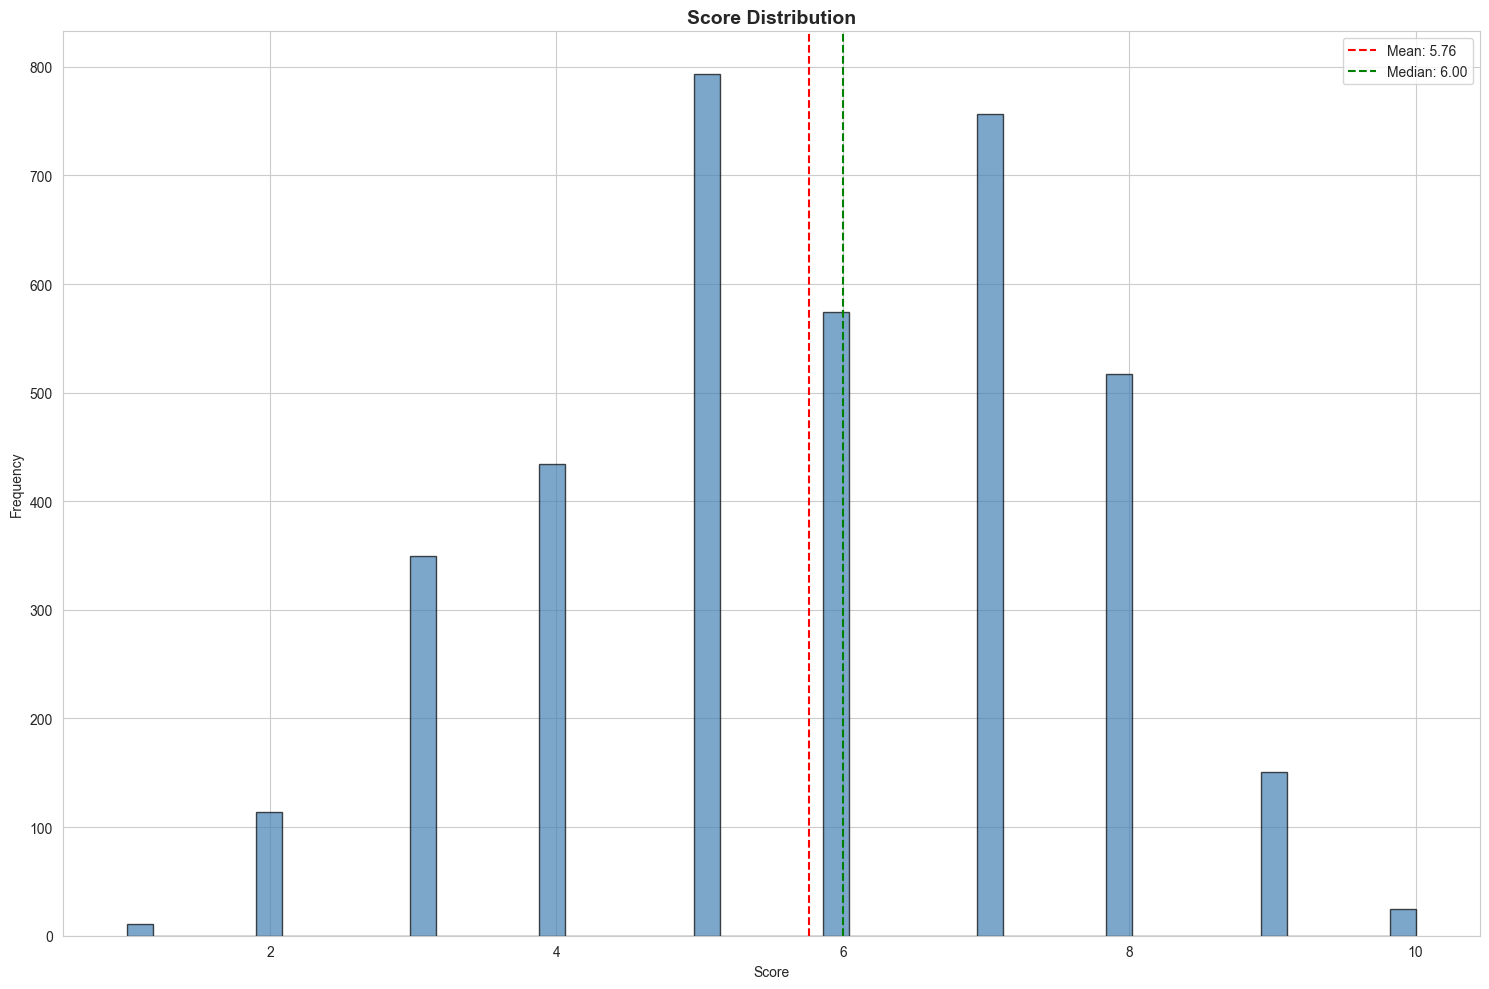

TARGET VARIABLE STATISTICS:
Mean: 5.764
Median: 6.000
Mode: 5.000
Standard Deviation: 1.806
Skewness: -0.145
Kurtosis: -0.661
Min: 1.000
Max: 10.000
Range: 9.000

Normality Test (D'Agostino-Pearson):
  Statistic: 174.152, p-value: 0.000000
  Distribution is NOT normal (p < 0.05)


In [32]:
fig, axes = plt.subplots(figsize=(15, 10))
# Histogram
axes.hist(df['score'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes.set_title('Score Distribution', fontsize=14, fontweight='bold')
axes.set_xlabel('Score')
axes.set_ylabel('Frequency')
axes.axvline(df['score'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["score"].mean():.2f}')
axes.axvline(df['score'].median(), color='green', linestyle='--', 
                    label=f'Median: {df["score"].median():.2f}')
axes.legend()


plt.tight_layout()
plt.show()

# Statistical tests
print("TARGET VARIABLE STATISTICS:")
print(f"Mean: {df['score'].mean():.3f}")
print(f"Median: {df['score'].median():.3f}")
print(f"Mode: {df['score'].mode().values[0]:.3f}")
print(f"Standard Deviation: {df['score'].std():.3f}")
print(f"Skewness: {skew(df['score'].dropna()):.3f}")
print(f"Kurtosis: {kurtosis(df['score'].dropna()):.3f}")
print(f"Min: {df['score'].min():.3f}")
print(f"Max: {df['score'].max():.3f}")
print(f"Range: {df['score'].max() - df['score'].min():.3f}")
print(f"\nNormality Test (D'Agostino-Pearson):")
stat, p_value = normaltest(df['score'].dropna())
print(f"  Statistic: {stat:.3f}, p-value: {p_value:.6f}")
if p_value < 0.05:
    print("  Distribution is NOT normal (p < 0.05)")
else:
    print("  Distribution is normal (p >= 0.05)")

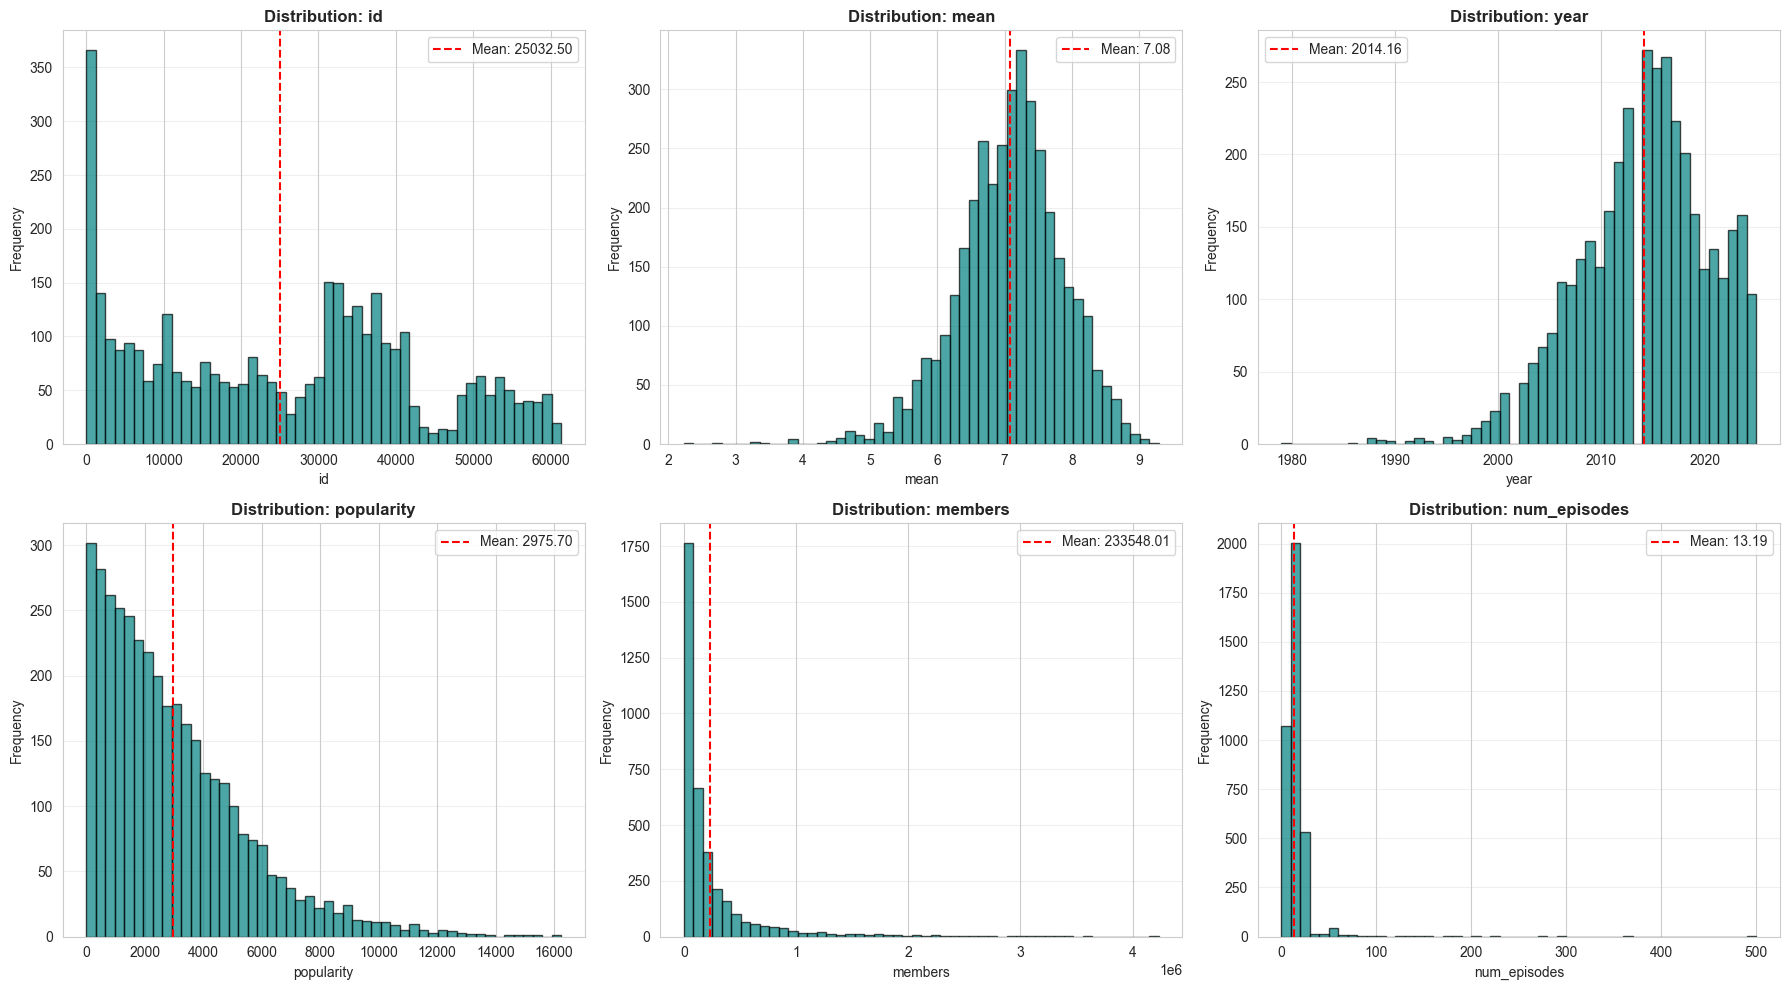

In [34]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'score' in numerical_cols:
    numerical_cols.remove('score')  # Already analyzed separately

n_cols = len(numerical_cols)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    data_to_plot = df[col].dropna()
    axes[idx].hist(data_to_plot, bins=50, edgecolor='black', alpha=0.7, color='teal')
    axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(data_to_plot.mean(), color='red', linestyle='--', 
                      label=f'Mean: {data_to_plot.mean():.2f}')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

# Hide extra subplots
for idx in range(n_cols, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

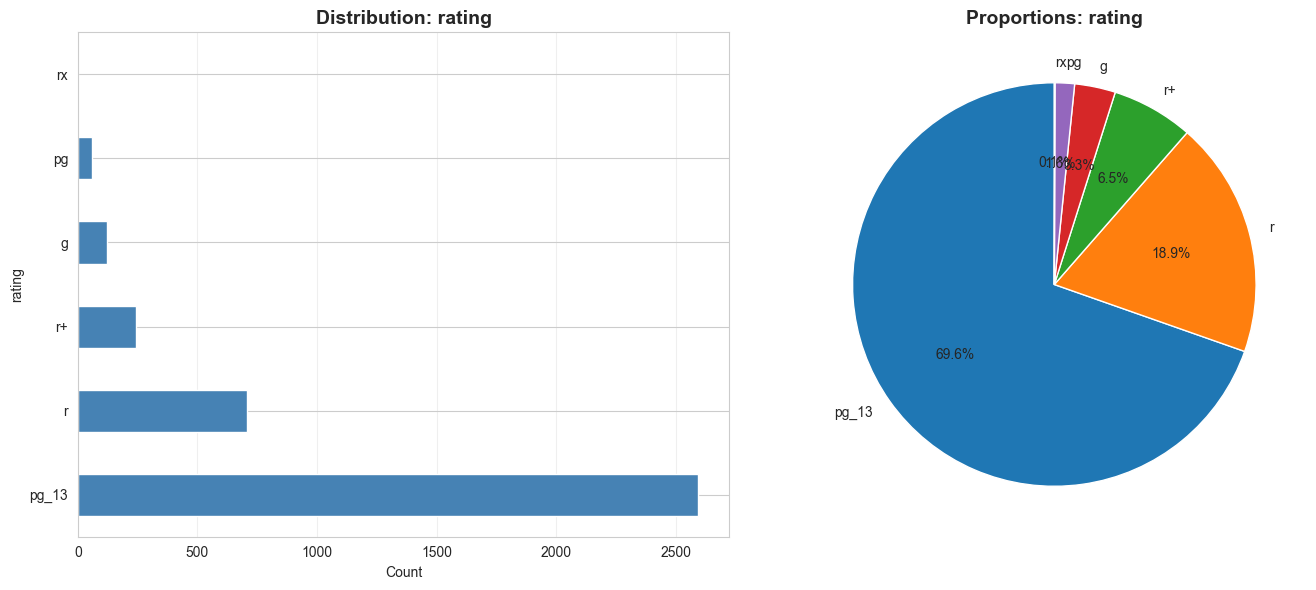


STATISTICS FOR rating:
Unique values: 6
Most frequent: pg_13 (2594 times)
Least frequent: 2 occurrences


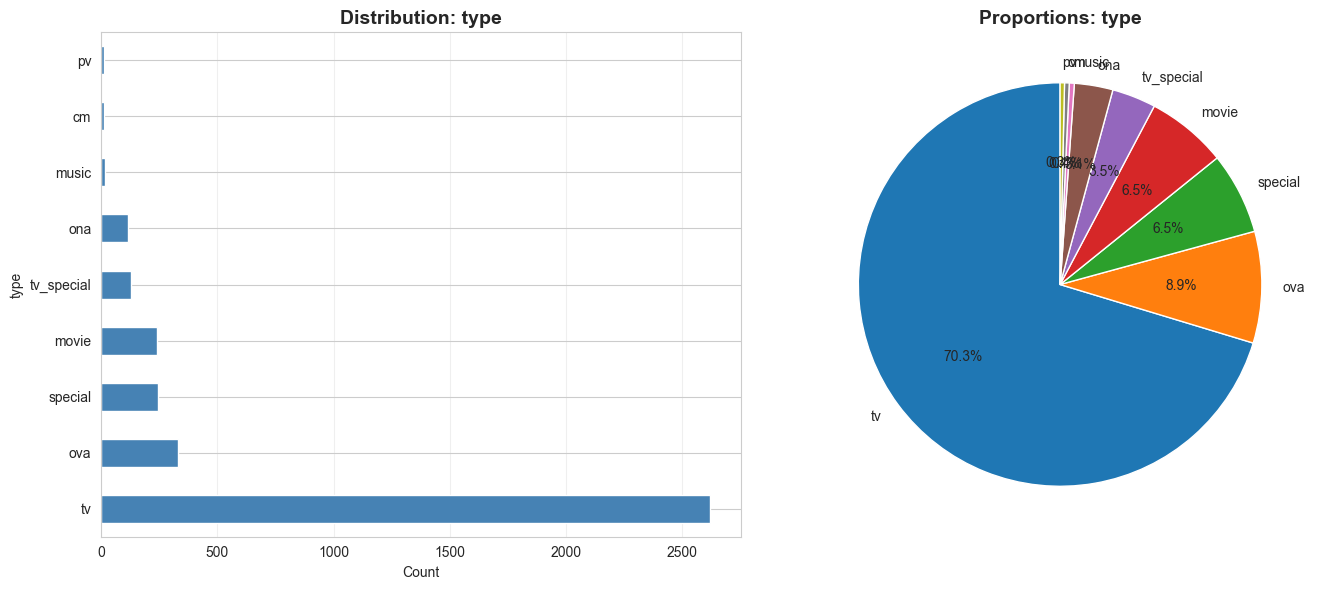


STATISTICS FOR type:
Unique values: 9
Most frequent: tv (2620 times)
Least frequent: 13 occurrences


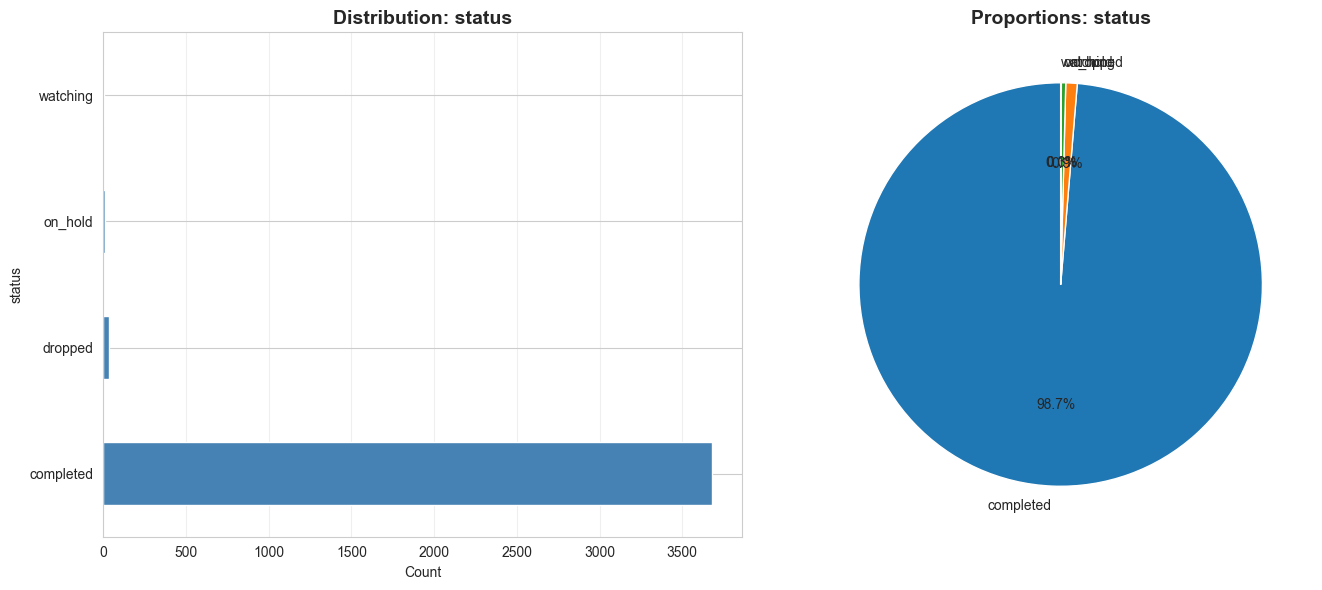


STATISTICS FOR status:
Unique values: 4
Most frequent: completed (3677 times)
Least frequent: 2 occurrences


In [35]:
categorical_cols = ['rating', 'type', 'status']
for col in categorical_cols:
    plt.figure(figsize=(14, 6))
    
    # Frequency table
    value_counts = df[col].value_counts()
    
    # If too many categories, show top 20
    if len(value_counts) > 20:
        value_counts = value_counts.head(20)
        title_suffix = " (Top 20)"
    else:
        title_suffix = ""
    
    plt.subplot(1, 2, 1)
    value_counts.plot(kind='barh', color='steelblue')
    plt.title(f'Distribution: {col}{title_suffix}', fontsize=14, fontweight='bold')
    plt.xlabel('Count')
    plt.grid(axis='x', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportions: {col}{title_suffix}', fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSTATISTICS FOR {col}:")
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most frequent: {df[col].mode().values[0]} ({df[col].value_counts().iloc[0]} times)")
    print(f"Least frequent: {value_counts.iloc[-1]} occurrences")

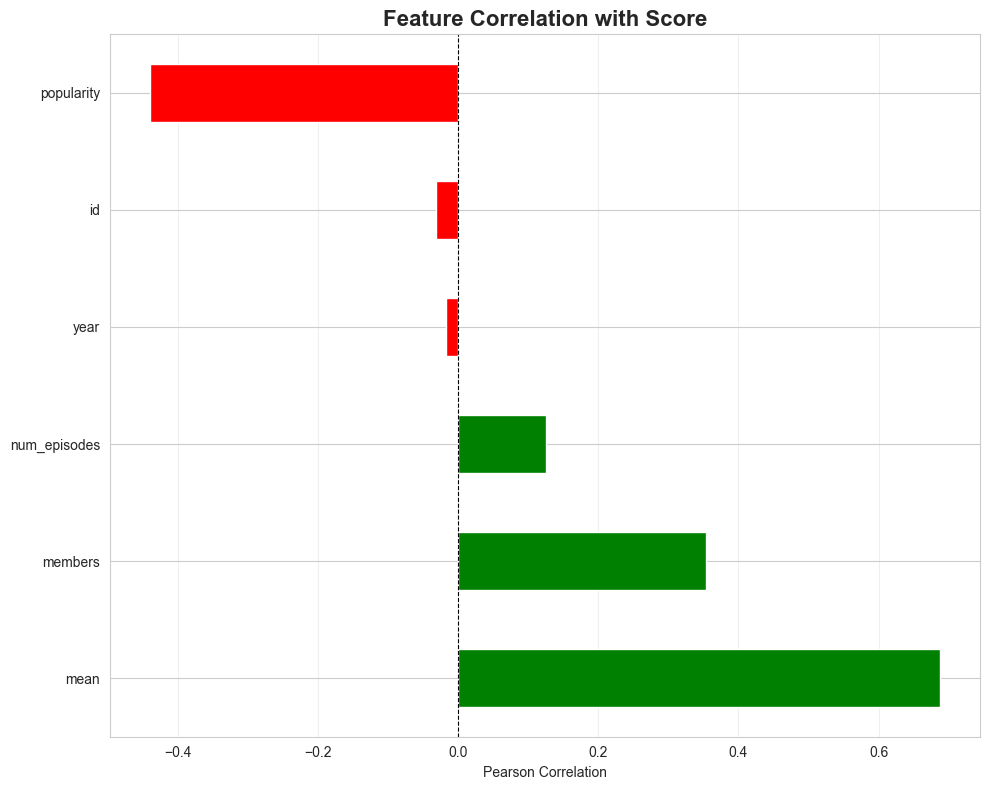

CORRELATION WITH TARGET VARIABLE:
score           1.000000
mean            0.688395
members         0.353234
num_episodes    0.125939
year           -0.017744
id             -0.032174
popularity     -0.440540
Name: score, dtype: float64


In [36]:
# Correlation of numerical features with score
correlations = df[numerical_cols + ['score']].corr()['score'].sort_values(ascending=False)

plt.figure(figsize=(10, max(8, len(correlations)*0.4)))
colors = ['green' if x > 0 else 'red' for x in correlations.drop('score')]
correlations.drop('score').plot(kind='barh', color=colors)
plt.title('Feature Correlation with Score', fontsize=16, fontweight='bold')
plt.xlabel('Pearson Correlation')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("CORRELATION WITH TARGET VARIABLE:")
print(correlations)